# Preprocessing


In [89]:
import warnings
warnings.filterwarnings('ignore')

In [90]:
import pydot_ng as pydot
pydot.InvocationException(1)

pydot_ng.InvocationException(1)

In [91]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.losses import BinaryCrossentropy
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot  as plt
import keras_tuner as kt


In [92]:
Stock = pd.read_csv('Dataset/1023.KL.csv')
Stock.head()
display(Stock)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-04-07,7.40,7.50,7.40,7.50,5.133926,18463400
1,2014-04-08,7.47,7.47,7.39,7.44,5.092854,11059000
2,2014-04-09,7.44,7.46,7.42,7.44,5.092854,14045800
3,2014-04-10,7.44,7.47,7.43,7.45,5.099699,14180500
4,2014-04-11,7.41,7.43,7.38,7.40,5.065474,14585600
...,...,...,...,...,...,...,...
2461,2024-04-01,6.68,6.69,6.64,6.66,6.660000,15773600
2462,2024-04-02,6.70,6.70,6.65,6.66,6.660000,14514400
2463,2024-04-03,6.66,6.66,6.52,6.56,6.560000,12189600
2464,2024-04-04,6.56,6.66,6.56,6.65,6.650000,13388400


In [93]:
# Calculation of historical moving averages of closing price (10 and 30 days of trading)
def MA(df, period):
    MA = pd.Series(df['Close'].rolling(period, min_periods=period).mean(), name='MA_' + str(period))
    return MA

Stock['MA10'] = MA(Stock, 10)
Stock['MA30'] = MA(Stock, 30)

#calculation of exponential moving average of closing price (10 and 30 days of trading)
def EMA(df, period):
    EMA = pd.Series(df['Close'].ewm(span=period, min_periods=period).mean(), name='EMA_' + str(period))
    return EMA

Stock['EMA10'] = EMA(Stock, 10)
Stock['EMA30'] = EMA(Stock, 30)


#Calculation of closing price momentum (10 and 30 days of trading)
def MOM(df, period):   
    MOM = pd.Series(df.diff(period), name='Momentum_' + str(period))   
    return MOM

Stock['MOM10'] = MOM(Stock['Close'], 10)
Stock['MOM30'] = MOM(Stock['Close'], 30)

In [94]:
Stock.head(40)

,Date,Open,High,Low,Close,Adj Close,Volume,MA10,MA30,EMA10,EMA30,MOM10,MOM30
0,2014-04-07,7.40,7.50,7.40,7.50,5.133926,18463400,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-04-08,7.47,7.47,7.39,7.44,5.092854,11059000,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-04-09,7.44,7.46,7.42,7.44,5.092854,14045800,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-04-10,7.44,7.47,7.43,7.45,5.099699,14180500,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-04-11,7.41,7.43,7.38,7.40,5.065474,14585600,NaN,NaN,NaN,NaN,NaN,NaN
5,2014-04-14,7.36,7.40,7.36,7.38,5.051784,7349100,NaN,NaN,NaN,NaN,NaN,NaN
6,2014-04-15,7.38,7.40,7.38,7.40,5.065474,6914000,NaN,NaN,NaN,NaN,NaN,NaN
7,2014-04-16,7.38,7.39,7.35,7.35,5.031247,3974600,NaN,NaN,NaN,NaN,NaN,NaN
8,2014-04-17,7.38,7.40,7.38,7.40,5.065474,3692700,NaN,NaN,NaN,NaN,NaN,NaN
9,2014-04-18,7.40,7.40,7.34,7.39,5.058628,1931700,7.415,NaN,7.399338,NaN,NaN,NaN


In [95]:
# Creating two columns SMA and LMA to label our dataset
# SMA (Short Moving Average)- The average of the closing price from the next five days in the future
# LMA (Long Moving Average)- The average of the closing price from the last ten days and the next five days in the future

full_data = Stock
full_data['SMA'] = ""
full_data['LMA'] = ""

for ind in range(0, (full_data.shape[0]-5)):
    sma_frame = full_data['Close'].iloc[ind+1:ind+6]
    full_data['SMA'].iloc[ind] = sma_frame.mean()
  
    lma_frame_one = full_data['Close'].iloc[ind-10:ind]
    lma_frame_two = full_data['Close'].iloc[ind+1:ind+6]

    if (lma_frame_one.sum() == 0):
        full_data['LMA'].iloc[ind] = np.NaN
    else: 
        full_data['LMA'].iloc[ind] = (lma_frame_one.sum() + lma_frame_two.sum())/15

full_data['SMA'] = full_data['SMA'].replace('', np.NaN)
full_data['LMA'] = full_data['LMA'].replace('', np.NaN)

#Dropping any empty fields of data
full_data = full_data.dropna(axis=0)
print(full_data.head())

          Date  Open  High   Low  Close  Adj Close   Volume   MA10      MA30  \
30  2014-05-21  7.40  7.40  7.35   7.36   5.038093  4696700  7.335  7.405667   
31  2014-05-22  7.40  7.41  7.35   7.38   5.051784  5179500  7.340  7.403667   
32  2014-05-23  7.37  7.37  7.28   7.31   5.003866  7004700  7.337  7.399333   
33  2014-05-26  7.31  7.36  7.29   7.31   5.003866  3796300  7.334  7.394667   
34  2014-05-27  7.30  7.34  7.30   7.33   5.017555  1798600  7.338  7.392333   

       EMA10     EMA30  MOM10  MOM30    SMA       LMA  
30  7.355942  7.384557   0.01  -0.14  7.338  7.335333  
31  7.360323  7.384224   0.05  -0.06  7.338  7.336000  
32  7.351161  7.378839  -0.03  -0.13  7.344  7.341333  
33  7.343669  7.373885  -0.03  -0.14  7.326  7.333333  
34  7.341182  7.370750   0.04  -0.07  7.308  7.325333  


In [96]:
#Creating target class - Signal
# The signal on a given trading day represents either 1-Buy or 0-Sell 
# The signal is calculated by comparing the future SMA and intermediate LMA
labelled_data = full_data
labelled_data['signal'] = np.where(labelled_data['SMA'] > labelled_data['LMA'], 1.0, 0.0)

#Dropping the SMA and LMA columns to avoid data leakage
labelled_data  = labelled_data.drop(columns = ['SMA', 'LMA'])
print(labelled_data.head(30))

          Date  Open  High   Low  Close  Adj Close    Volume   MA10      MA30  \
30  2014-05-21  7.40  7.40  7.35   7.36   5.038093   4696700  7.335  7.405667   
31  2014-05-22  7.40  7.41  7.35   7.38   5.051784   5179500  7.340  7.403667   
32  2014-05-23  7.37  7.37  7.28   7.31   5.003866   7004700  7.337  7.399333   
33  2014-05-26  7.31  7.36  7.29   7.31   5.003866   3796300  7.334  7.394667   
34  2014-05-27  7.30  7.34  7.30   7.33   5.017555   1798600  7.338  7.392333   
35  2014-05-28  7.30  7.38  7.30   7.36   5.038093   6480400  7.343  7.391667   
36  2014-05-29  7.31  7.38  7.31   7.38   5.051784   4448900  7.350  7.391000   
37  2014-05-30  7.39  7.40  7.34   7.34   5.024402  14127000  7.352  7.390667   
38  2014-06-02  7.34  7.34  7.19   7.22   4.942258   5670400  7.337  7.384667   
39  2014-06-03  7.24  7.28  7.18   7.24   4.955950  10811600  7.323  7.379667   
40  2014-06-04  7.24  7.24  7.20   7.22   4.942258   2607100  7.309  7.370333   
41  2014-06-05  7.24  7.24  

In [97]:
# Creating the MinMaxScaler Object
scaler = MinMaxScaler()

temp = labelled_data.drop(['Date', 'signal'], axis=1)
cols = temp.columns

#Creating scaled data
temp = scaler.fit_transform(temp)

#Generating input_df which will be used for model training and predictions
input_df = pd.concat([labelled_data['Date'],pd.DataFrame(temp, columns = cols),
                      labelled_data['signal']], 
                      axis=1, ignore_index=False)

input_df = input_df.dropna(axis=0)
print(input_df.head())
print(input_df.tail())

          Date      Open      High       Low     Close  Adj Close    Volume  \
30  2014-05-21  0.986637  0.986517  0.988764  0.988889   0.609598  0.018138   
31  2014-05-22  0.982183  0.984270  0.982022  0.977778   0.601343  0.028106   
32  2014-05-23  0.975501  0.973034  0.952809  0.948889   0.579882  0.044198   
33  2014-05-26  0.951002  0.968539  0.961798  0.968889   0.594740  0.026782   
34  2014-05-27  0.966592  0.973034  0.977528  0.973333   0.598042  0.055122   

        MA10      MA30     EMA10     EMA30     MOM10     MOM30  signal  
30  0.993343  0.970487  0.988797  0.979541  0.668161  0.540462     1.0  
31  0.993343  0.969875  0.988326  0.979600  0.609865  0.520231     1.0  
32  0.989669  0.968805  0.982534  0.977685  0.538117  0.502890     1.0  
33  0.988062  0.968423  0.981538  0.977259  0.578475  0.528902     0.0  
34  0.986915  0.968040  0.981554  0.977165  0.587444  0.528902     0.0  
            Date      Open      High       Low     Close  Adj Close    Volume  \
2426  

In [98]:
# Splitting entire data to create Training and Testing Data
# We will need to split the training and testing data into equivalent 
# time steps to train the Model

# Creating Training and Testing indices
train_data_size = int((0.7)*(input_df.shape[0]))
test_data_size = int(input_df.shape[0] - train_data_size)

# Allocating data instances to training and testing sets, excluding the date
train_data = input_df.iloc[0:train_data_size,1:]
test_data = input_df.iloc[train_data_size:input_df.shape[0],1:]


full_training_data = train_data # Used during model prediction
full_test_data = test_data  # Used during model prediction

# Creating numpy arrays from dataframes for future processing
train_data = np.array(train_data)
test_data = np.array(test_data)

print(train_data.shape)
print(test_data.shape)

(1680, 13)
(721, 13)


In [99]:
# Creating X_train and y_train
# As an example, this function looks back at five days of trading:
# X - Consists of all features excluding signal from last 5 days 
# y - Consists of signal from one day ahead

X_train = []
y_train = []

time_step = 5
label_col = (train_data.shape[1]-1)

for i in range(time_step, train_data.shape[0]):
    X_train.append(train_data[i-time_step:i,:label_col])
    y_train.append(train_data[i,label_col])
    
X_train, y_train = np.array(X_train), np.array(y_train)

print('\nShapes of X_train and Y_train:\n')
print(X_train.shape)
print(y_train.shape)

print('\nFirst Element in X_train and Y_train:\n')
print(X_train[0])
print(y_train[0])


Shapes of X_train and Y_train:

(1675, 5, 12)
(1675,)

First Element in X_train and Y_train:

[[0.98663697 0.98651685 0.98876404 0.98888889 0.60959765 0.01813754
  0.99334252 0.97048704 0.98879743 0.97954069 0.66816143 0.54046243]
 [0.98218263 0.98426966 0.98202247 0.97777778 0.6013432  0.02810556
  0.99334252 0.96987537 0.98832577 0.97959954 0.60986547 0.52023121]
 [0.97550111 0.97303371 0.95280899 0.94888889 0.57988154 0.04419756
  0.98966942 0.96880495 0.98253388 0.97768469 0.53811659 0.50289017]
 [0.95100223 0.96853933 0.96179775 0.96888889 0.59473959 0.02678203
  0.98806244 0.96842266 0.98153767 0.97725937 0.57847534 0.52890173]
 [0.96659243 0.97303371 0.97752809 0.97333333 0.59804176 0.05512158
  0.9869146  0.96804037 0.98155428 0.97716471 0.58744395 0.52890173]]
0.0


In [100]:
# Creating X_test and y_test
# As an example, this function looks back at five days of trading:
# X - Consists of all features excluding signal from last 5 days 
# y - Consists of signal from one day ahead

X_test = []
y_test = []

# Gathering the last five days of training data as this 
# will be used to predict the first few labels in y_test
last_5_days = full_training_data.tail()
test_data_df = pd.concat([last_5_days, full_test_data], ignore_index=True)

for i in range(time_step, test_data_df.shape[0]):
    X_test.append(test_data_df.iloc[i-time_step:i,:label_col])
    y_test.append(test_data_df.iloc[i, label_col])

X_test, y_test = np.array(X_test), np.array(y_test)
print('\nShapes of X_test and Y_test:\n')
print(X_test.shape)
print(y_test.shape)

print('\nFirst Element in X_test and Y_test:\n')
print(X_test[0])
print(y_test[0])



Shapes of X_test and Y_test:

(721, 5, 12)
(721,)

First Element in X_test and Y_test:

[[0.30289532 0.30786517 0.30786517 0.30888889 0.29910758 0.02675158
  0.31244261 0.32020797 0.31189604 0.30350617 0.5426009  0.53179191]
 [0.30734967 0.30561798 0.2988764  0.3        0.29068865 0.04400749
  0.30808081 0.32043734 0.30766518 0.30165693 0.52466368 0.55202312]
 [0.30066815 0.2988764  0.29662921 0.29555556 0.28647919 0.02776021
  0.30280073 0.32005505 0.30337188 0.29962849 0.50672646 0.52890173]
 [0.29621381 0.29662921 0.29662921 0.30666667 0.29700285 0.02149095
  0.30142332 0.31997859 0.3019384  0.29847717 0.58295964 0.54046243]
 [0.30512249 0.3011236  0.30337079 0.31111111 0.30121207 0.01774131
  0.30004591 0.31944338 0.30159723 0.29769865 0.58295964 0.52312139]]
1.0


In [101]:
from sklearn.model_selection import train_test_split

# Assuming X_train and y_train are your training data
# You can adjust the test_size parameter to control the proportion of the dataset to include in the test split
# For example, setting test_size=0.2 means that 20% of the data will be used for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Now X_train and y_train are used for training, and X_val and y_val are used for validation

# Model Training


In [112]:
# Model definition
def build_model():

    model = Sequential()

    model.add(LSTM(units = 30, activation = 'relu',input_shape = (X_train.shape[1], X_train.shape[2])))
    
    model.add(Dropout(0.2))
   
    model.add(Dense(units = 10, activation = 'relu'))
           
    model.add(Dense(units = 1, activation = 'sigmoid'))
   
    print(model.summary())

    return model

# Model Compile
def compile_model(model):

    met = [keras.metrics.BinaryAccuracy(name='accuracy'),keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall'), keras.metrics.AUC(name='auc')]
    
    model.compile(optimizer='adam', loss = BinaryCrossentropy(), metrics = met)

    return model

# Model Training
def train_model(model, X_train, Y_train):
    
    batch_size = 32
    epochs = 80

    #Capturing the unique counts of 0 and 1 signal classes
    (unique,counts) = np.unique(Y_train, return_counts=True)
    frequencies = np.asarray((unique, counts)).T

    neg = frequencies[0][1]
    pos= frequencies[1][1]
    total = neg+pos

    #Calculating weights for teh two binary classes
    weight_for_0 = (1 / neg)*(total)/2.0 
    weight_for_1 = (1 / pos)*(total)/2.0
    
    #Defining parameters for the class weights
    cw = {0: weight_for_0, 1: weight_for_1}
       
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose = 1)

    return model, history

# Model Evaluation and Results Evaluation
def eval_model(m, test_X, test_y):

    y_pred = m.predict(test_X)
    y_pred = y_pred.flatten()
    
    # Round predictions to two decimal places
    y_pred_rounded = np.round(y_pred, decimals=2)
    
    print('PREDICTED SIGNAL: \n')

    # Print head (first few elements) of the array
    print(y_pred_rounded[:5])  # Print first 5 elements

    # Print tail (last few elements) of the array
    print(y_pred_rounded[-5:])  # Print last 5 elements

    def map_signal(prediction):
        if prediction <= 0.2:
            return 'Strong Sell'
        elif prediction <= 0.4:
            return 'Sell'
        elif prediction <= 0.6:
            return 'Neutral'
        elif prediction <= 0.8:
            return 'Buy'
        else:
            return 'Strong Buy'

# Apply the function to each rounded prediction
    signals = [map_signal(pred) for pred in y_pred_rounded]

# Print the signals
    print('Head of the signal array:')
    print(signals[:10])

# Print the tail of the array
    print('\nTail of the signal array:')
    print(signals[-10:])
    
    print('CONFUSION MATRIX: \n')
    unique_label = np.unique([test_y, y_pred.round()])
    cmtx = pd.DataFrame(
    confusion_matrix(test_y, y_pred.round(), labels=unique_label), 
    index=['  true:{:}'.format(x) for x in unique_label], 
    columns=['pred:{:}'.format(x) for x in unique_label])
    print(cmtx)


    print('\nCLASSFICATION REPORT: \n')
    print(classification_report(test_y, y_pred.round()))

    # Visualising the results
    print('\nMODEL PREDICTIONS VS ACTUAL: \n')
    plt.figure(figsize=(14,5))
    plt.plot(test_y, color = 'red', label = 'Actual Buy/Sell Signal ')
    plt.plot(y_pred, color = 'blue', label = 'Predicted Buy/Sell Signal')
    plt.title('1023.KL LSTM Stock Buy/Sell Prediction')
    plt.xlabel('Time')
    plt.ylabel('1023.KL Stock Signal')
    plt.legend(loc='best')
    plt.show()
   
    return None

In [113]:
# Class Imbalance
(unique,counts) = np.unique(y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print('Training Instances with Class 0:  ' + str(frequencies[0][1]))
print('Training Instances with Class 1:  ' + str(frequencies[1][1]))
total = int(frequencies[0][1]) + int(frequencies[1][1])
print('Total Training instances:  '+str(total))

Training Instances with Class 0:  728.0
Training Instances with Class 1:  612.0
Total Training instances:  1340


In [114]:
# Executing model building, compiling and training 
# During model training, we print the 
model = build_model()
model = compile_model(model)
model, history = train_model(model, X_train, y_train)

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_39 (LSTM)                  │ (None, 30)             │         5,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,481 (21.41 KB)

 Trainable params: 5,481 (21.41 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 64s 30ms/step - accuracy: 0.5509 - auc: 0.4680 - loss: 0.6919 - precision: 0.4902 - recall: 0.1038
Epoch 2/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5659 - auc: 0.5547 - loss: 0.6892 - precision: 0.5425 - recall: 0.2322
Epoch 3/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5663 - auc: 0.5777 - loss: 0.6842 - precision: 0.6202 - recall: 0.1059    
Epoch 4/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5800 - auc: 0.6274 - loss: 0.6803 - precision: 0.6837 - recall: 0.2345
Epoch 5/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5709 - auc: 0.6556 - loss: 0.6692 - precision: 0.5446 - recall: 0.1790       
Epoch 6/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6331 - auc: 0.6818 - loss: 0.6489 - precision: 0.6593 - recall: 0.3856
Epoch 7/80
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6742 - auc: 0.7386 - loss: 0.6118 - precision: 0.6811 - recall: 0.5514
Epoch 8/80
42/42 ━━━━━━━━━━━━━━━━━━━


MODEL TRAINING RESULTS



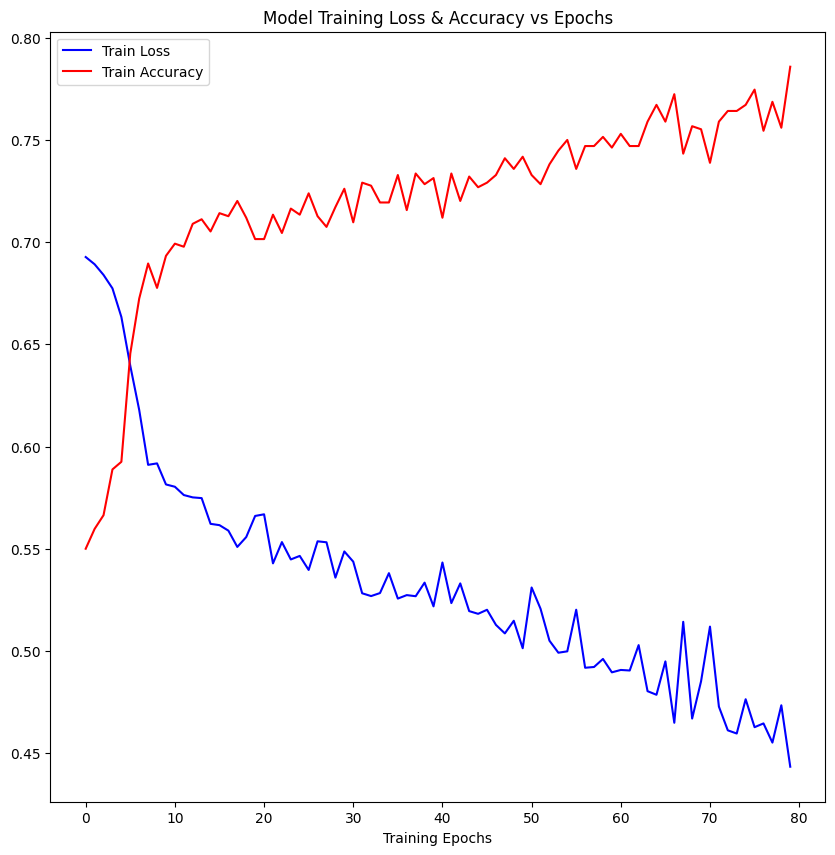

In [115]:
# Plotting Training loss vs Epochs 
def plot_curves(history): 
    
    print('\nMODEL TRAINING RESULTS\n')
    plt.figure(figsize=(10,10))
    plt.plot(history.history['loss'], color = 'blue')
    plt.plot(history.history['accuracy'], color = 'red')
    plt.title('Model Training Loss & Accuracy vs Epochs')
    plt.xlabel('Training Epochs')
    plt.legend(['Train Loss', 'Train Accuracy'], loc='best')
    plt.show()
        
plot_curves(history)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
PREDICTED SIGNAL: 

[0.81 0.9  0.8  0.61 0.39]
[0.39 0.38 0.37 0.38 0.43]
Head of the signal array:
['Strong Buy', 'Strong Buy', 'Strong Buy', 'Buy', 'Sell', 'Sell', 'Strong Sell', 'Strong Sell', 'Strong Sell', 'Strong Sell']

Tail of the signal array:
['Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Sell', 'Neutral']
CONFUSION MATRIX: 

          pred:0.0  pred:1.0
true:0.0       296        11
true:1.0       303       111

CLASSFICATION REPORT: 

              precision    recall  f1-score   support

         0.0       0.49      0.96      0.65       307
         1.0       0.91      0.27      0.41       414

    accuracy                           0.56       721
   macro avg       0.70      0.62      0.53       721
weighted avg       0.73      0.56      0.52       721


MODEL PREDICTIONS VS ACTUAL: 



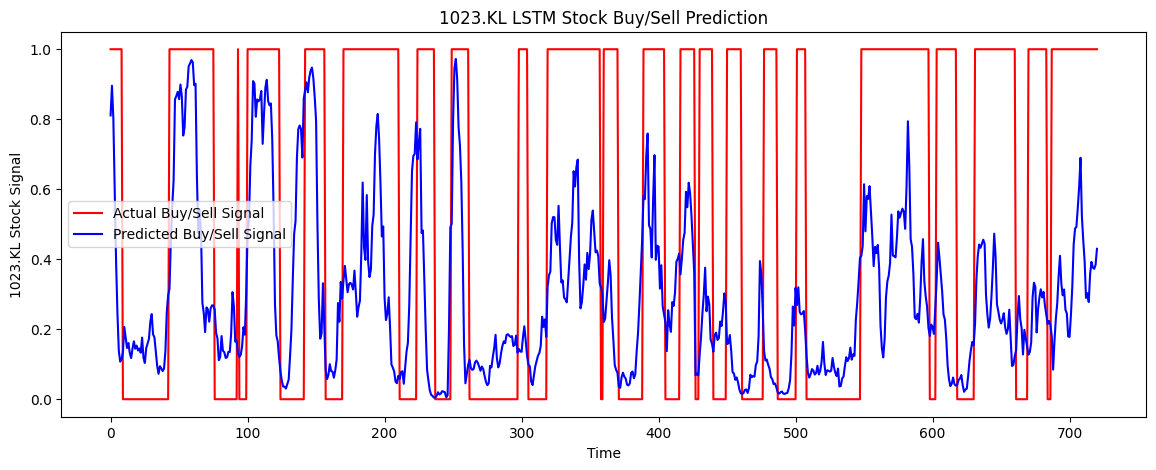

In [116]:
# Testing Initial Model 
# Printing Confusion Matrix, Classification Report, and Visualizing Predicted Signal
tf.keras.utils.plot_model(model, to_file='img/1023.KL-LSTM.png', show_shapes=True)
eval_model(model, X_test, y_test)

In [19]:

def model_builder(hp):

    #Defining Model 
    hyper_model = Sequential()

    hyper_model.add(LSTM(units = hp.Int('input_layer', 10, 90, step=10), activation = 'relu', input_shape = (X_train.shape[1], X_train.shape[2])))
    hyper_model.add(Dropout(hp.Choice('Drop1', values = [0.1,0.2,0.3])))
        
    hyper_model.add(Dense(units = hp.Choice('hidden_1', values = [10,20,30,60,80,100]), activation = 'relu'))
        
    hyper_model.add(Dense(units = 1, activation = 'sigmoid'))
        
    hyper_model.compile(optimizer = Adam(learning_rate=hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])),
                        loss = BinaryCrossentropy(), metrics=['accuracy'])
        
    return hyper_model

In [20]:
# Defining Random Search Tuner and performing hyperparameter tuning
obj = kt.Objective("loss", direction="min")
tuner = kt.tuners.RandomSearch(model_builder, objective=obj, max_trials=25, seed=42, overwrite = True)

tuner.search(X_train, y_train, epochs=80, validation_data=(X_val, y_val))

# Get the optimal hyperparameter values for model layers
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. 

The optimal number of units in the input layer is {best_hps.get('input_layer')}. 
The optimal amount of dropout in the input layer is {best_hps.get('Drop1')}. 
The optimal number of units in the first hidden layer is {best_hps.get('hidden_1')}. 
The optimal learning rate is {best_hps.get('learning_rate')}.
""")


Trial 25 Complete [00h 00m 25s]
loss: 0.47151556611061096

Best loss So Far: 0.4052547812461853
Total elapsed time: 00h 10m 41s

The hyperparameter search is complete. 

The optimal number of units in the input layer is 50. 
The optimal amount of dropout in the input layer is 0.1. 
The optimal number of units in the first hidden layer is 30. 
The optimal learning rate is 0.001.



In [52]:
import json

# Convert the HyperParameters object to a dictionary
best_hps_dict = best_hps.values

# Save the dictionary to a JSON file
with open('best_hps.json', 'w') as f:
    json.dump(best_hps_dict, f)

In [107]:
# Assuming best_hps_dict is a simplified dictionary of hyperparameters
with open('1023_best_hps.json', 'r') as f:
    best_hps_dict = json.load(f)

# Create a new HyperParameters object
savedbesthps = kt.HyperParameters()

# Manually add each hyperparameter to the new object
for key, value in best_hps_dict.items():
    if key == 'input_layer':
        savedbesthps.Int(key, min_value=value, max_value=value, step=1)
    elif key == 'Drop1':
        savedbesthps.Float(key, min_value=0.0, max_value=1.0, step=0.1)
    elif key == 'hidden_1':
        savedbesthps.Int(key, min_value=value, max_value=value, step=1)
    elif key == 'learning_rate':
        savedbesthps.Float(key, min_value=value, max_value=value, step=0.001)

print(savedbesthps.get('input_layer'))

50


In [1]:
#Step One
model_Two = tuner.hypermodel.build(savedbesthps)
history = model_Two.fit(X_train, y_train, epochs=200)

acc_per_epoch = history.history['accuracy']
best_epoch = acc_per_epoch.index(max(acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

NameError: name 'tuner' is not defined

In [109]:
#Step Two
model_three = tuner.hypermodel.build(savedbesthps)

# Retrain the final model using the best number of epochs
tuned_history = model_three.fit(X_train, y_train, epochs=best_epoch)

Epoch 1/198
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4917 - loss: 0.6950
Epoch 2/198
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5685 - loss: 0.6834
Epoch 3/198
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6013 - loss: 0.6785
Epoch 4/198
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6117 - loss: 0.6553
Epoch 5/198
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6565 - loss: 0.6227
Epoch 6/198
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6789 - loss: 0.6202
Epoch 7/198
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6786 - loss: 0.6056
Epoch 8/198
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6918 - loss: 0.5862
Epoch 9/198
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6911 - loss: 0.5949
Epoch 10/198
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6760 - loss: 0.6018
Epoch 11/198
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6876 - loss: 0.5837
Epoch 12/198
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy:


MODEL TRAINING RESULTS



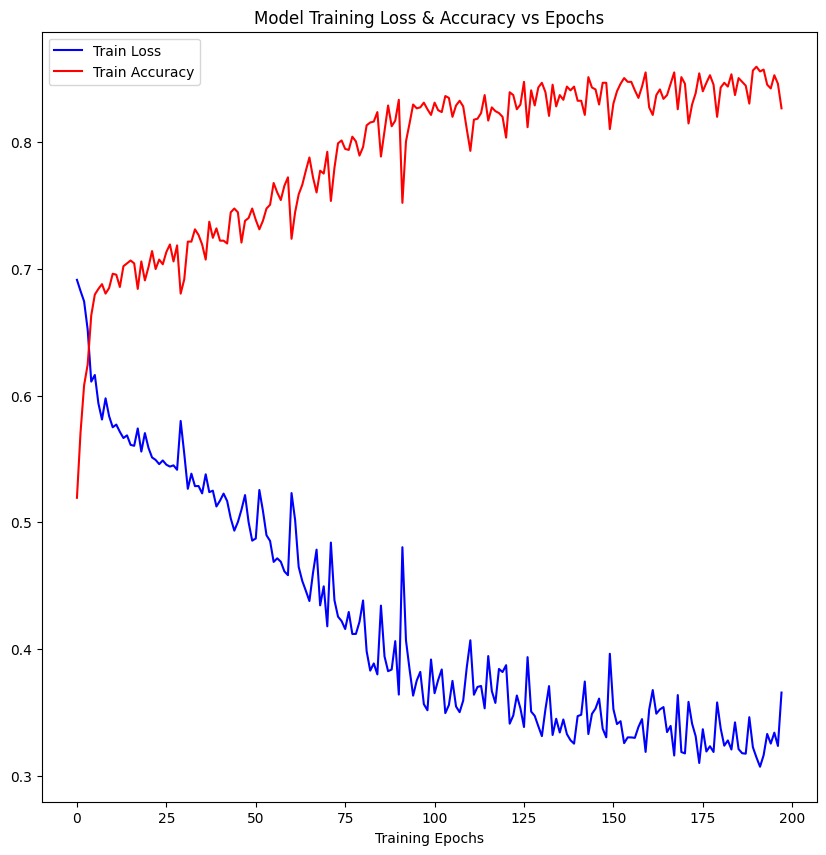

In [110]:
plot_curves(tuned_history)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8363 - loss: 0.4279
[test loss, test accuracy]: [0.40986379981040955, 0.8391123414039612]
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
PREDICTED SIGNAL: 

[0.99 1.   0.99 0.95 0.6 ]
[0.98 0.98 0.98 0.97 0.98]
Head of the signal array:
['Strong Buy', 'Strong Buy', 'Strong Buy', 'Strong Buy', 'Buy', 'Sell', 'Strong Sell', 'Strong Sell', 'Strong Sell', 'Strong Sell']

Tail of the signal array:
['Strong Buy', 'Strong Buy', 'Strong Buy', 'Strong Buy', 'Strong Buy', 'Strong Buy', 'Strong Buy', 'Strong Buy', 'Strong Buy', 'Strong Buy']
CONFUSION MATRIX: 

          pred:0.0  pred:1.0
true:0.0       233        74
true:1.0        42       372

CLASSFICATION REPORT: 

              precision    recall  f1-score   support

         0.0       0.85      0.76      0.80       307
         1.0       0.83      0.90      0.87       414

    accuracy                           0.84       721
   macro avg       0.84      0.83      0.83       721
weighted avg 

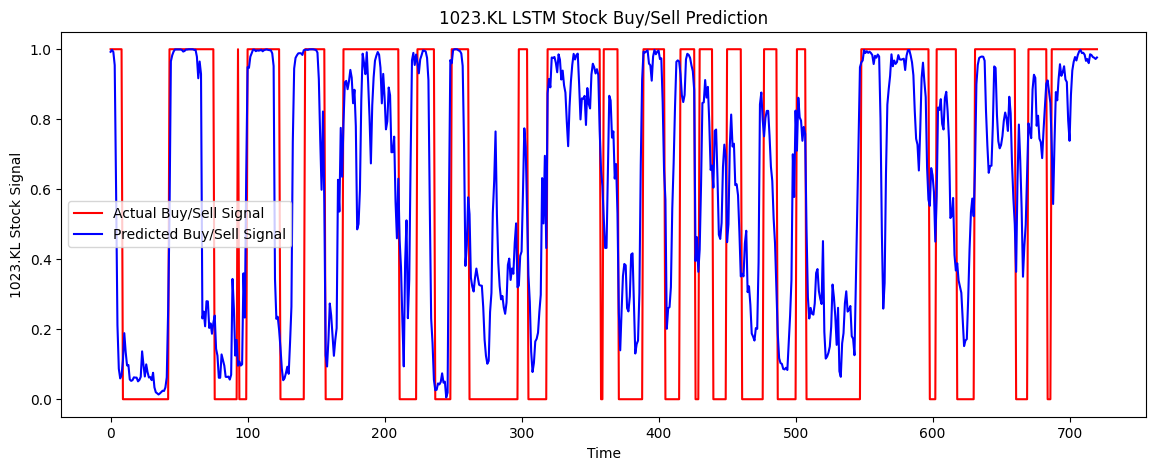

In [111]:
# Tuned Model Evaluation
# Printing Confusion Matrix, Classification Report, and Visualizing the Predicted Signal
eval_result = model_three.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

tf.keras.utils.plot_model(model_three, to_file='img/1023.KL-LSTM-Tuned.png', show_shapes=True)

eval_model(model_three, X_test, y_test)

In [50]:
from sklearn.model_selection import StratifiedKFold

# Define the number of folds for cross-validation
num_folds = 3

# Initialize the StratifiedKFold object
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)

# Lists to store the performance metrics for each fold
val_acc_per_fold = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(kfold.split(X_train, y_train), 1):
    print(f"Fold {fold}/{num_folds}:")
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Build the model
    model = build_model()  # Assuming you have defined a function build_model() to create the model
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model on the training data of this fold
    history = model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32, verbose=0, validation_data=(X_val_fold, y_val_fold))
    
    # Evaluate the model on the validation set of this fold
    _, val_accuracy = model.evaluate(X_val_fold, y_val_fold)
    print(f"Validation Accuracy: {val_accuracy}")
    val_acc_per_fold.append(val_accuracy)

# Print the average validation accuracy across all folds
average_val_accuracy = np.mean(val_acc_per_fold)
print(f"\nAverage Validation Accuracy: {average_val_accuracy}")

Fold 1/3:


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 30)             │         5,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,481 (21.41 KB)

 Trainable params: 5,481 (21.41 KB)

 Non-trainable params: 0 (0.00 B)

None
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6307 - loss: 0.5886 
Validation Accuracy: 0.646532416343689
Fold 2/3:


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_29 (LSTM)                  │ (None, 30)             │         5,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,481 (21.41 KB)

 Trainable params: 5,481 (21.41 KB)

 Non-trainable params: 0 (0.00 B)

None
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7514 - loss: 0.4932 
Validation Accuracy: 0.7651006579399109
Fold 3/3:


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 30)             │         5,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,481 (21.41 KB)

 Trainable params: 5,481 (21.41 KB)

 Non-trainable params: 0 (0.00 B)

None
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7874 - loss: 0.5003 
Validation Accuracy: 0.7488788962364197

Average Validation Accuracy: 0.7201706568400065
